In [1]:
import pandas as pd
import re
import pickle
from tqdm import tqdm_notebook
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## Read data from sentiment 140

In [2]:
sentiment = pd.read_csv("sentiment140.csv", encoding = "ISO-8859-1")
sentiment.columns=['polarity','tweetid','date','nq','author','tweet']
sentiment = sentiment.drop(["tweetid","date","nq","author"],axis=1)

## Functions for cleaning the tweets

In [3]:
stop_words = set(stopwords.words('english'))



def cleanText(s):
    bad_chars = [';', ':', '!', '*', '(' , ')', '&','[',']','.','?','{','}']
    non_ascii = "".join(i for i in s if ord(i)< 128)
    
    html_decoded_string = BeautifulSoup(non_ascii, "lxml")
    string = html_decoded_string.string
    
    non_name = " ".join((filter(lambda x:x[0]!='@', string.split())))
    non_badchars = ''.join(filter(lambda i: i not in bad_chars, non_name))
    non_links = re.sub(r"http\S+", "", non_badchars)
    
    non_links = stopwords_stem(non_links)
    
    return non_links

def stopwords_stem(document): 
    words = word_tokenize(document)
    words = removeStopwords(words)
    words = stemWords(words)
    result = ""
    for word in words:
        result += word + " "
    return result

def removeStopwords(document):
    result = []
    for word in document:
        if word not in stop_words:
            result.append(word)
    return result

def stemWords(document):
    """Stem words in list of tokenized words"""
    stemmer = PorterStemmer()
    result = []
    for word in document:
        stem = stemmer.stem(word)
        result.append(stem)
    return result

## Cleaning tweets from dataframe and transform to list
#### Can skip if load from disk (below)

In [4]:
tweets = sentiment.tweet
print("Cleaning Tweets: ")
tweets = [cleanText(t) for t in tqdm_notebook(tweets)]
polarity = sentiment.polarity.tolist()

Cleaning Tweets: 


E:\jupyter\lib\site-packages\bs4\__init__.py:272: UserWarning: "b' i just received my G8 viola exam.. and its... well... .. disappointing.. :\\..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
E:\jupyter\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'E3 ON PLAYSTATION HOME IN ABOUT AN HOUR!!!!!!!!!! \\../  \\../'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


### Save the processed tweets for later use

In [5]:
with open('tweets.pickle', 'wb') as f:
    pickle.dump(tweets, f)
with open('polarity.pickle', 'wb') as f:
    pickle.dump(polarity, f)

### Load from saved files

In [22]:
with open('tweets.pickle', 'rb') as f:
    tweets = pickle.load(f)
with open('polarity.pickle', 'rb') as f:
    polarity = pickle.load(f)

In [21]:
for i in range(10):
    print(sentiment.tweet[i])
    print(tweets[i]+"\n")

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
upset ca n't updat facebook text might cri result school today also blah 

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
I dive mani time ball manag save 50 % the rest go bound 

my whole body feels itchy and like its on fire 
whole bodi feel itchi like fire 

@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
, 's behav 'm mad I ca n't see 

@Kwesidei not the whole crew 
whole crew 

Need a hug 
need hug 

@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?
hey long time see ye rain bit , bit lol , I 'm fine thank , 's 

@Tatiana_K nope they didn't have it 
nope n't 

@twittera que me muera ? 
que muera 

spring break in plain city... it's snowing 
spring break plain citi 's snow 



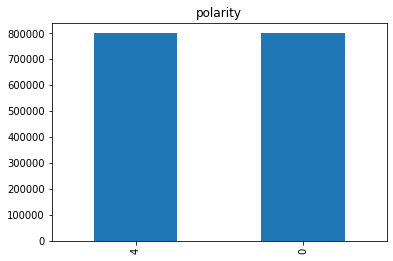

In [11]:
sentiment.polarity.value_counts().plot(kind="bar",subplots="True")
plt.show()

### Count Vectorizer

In [15]:
print("Running Count Vectorizer: ")
count_vectorizer = CountVectorizer(binary=True)
train_vector = count_vectorizer.fit_transform(tweets)

print("Train Test Split: ")
X_train, X_test, y_train, y_test = train_test_split(train_vector, polarity, test_size=0.33, random_state=123)

print("\nTraining Naive Bayes:")
clf = MultinomialNB().fit(X_train, y_train)

print("Testing: ")
predicted = clf.predict(X_test)

print("Accuracy" , accuracy_score(y_test, predicted))
print("Precision" , precision_score(y_test, predicted, pos_label=4))

print("\nTraining SVM:")
svmclf = svm.LinearSVC().fit(X_train, y_train)

print("Testing: ")
predicted = svmclf.predict(X_test)

print("\nAccuracy" , accuracy_score(y_test, predicted))
print("Precision" , precision_score(y_test, predicted, pos_label=4))

Running Count Vectorizer: 
Train Test Split: 

Training Naive Bayes:
Testing: 
Accuracy 0.7660018939393939
Precision 0.7731212692733954

Training SVM:


E:\jupyter\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Testing: 

Accuracy 0.7692935606060606
Precision 0.7575905779381451


### TF-IDF

In [16]:
print("Running TF-IDF Vectorizer: ")
tfidf_vectorizer = TfidfVectorizer()
train_vector = tfidf_vectorizer.fit_transform(tweets)

print("Train Test Split: ")
X_train, X_test, y_train, y_test = train_test_split(train_vector, polarity, test_size=0.33, random_state=123)

print("\nTraining Naive Bayes:")
nbclf = MultinomialNB().fit(X_train, y_train)

print("Testing: ")
predicted = nbclf.predict(X_test)

print("Accuracy" , accuracy_score(y_test, predicted))
print("Precision" , precision_score(y_test, predicted, pos_label=4))

print("\nTraining SVM:")
svmclf = svm.LinearSVC().fit(X_train, y_train)

print("Testing: ")
predicted = svmclf.predict(X_test)

print("\nAccuracy" , accuracy_score(y_test, predicted))
print("Precision" , precision_score(y_test, predicted, pos_label=4))

Running TF-IDF Vectorizer: 
Train Test Split: 

Training Naive Bayes:
Testing: 
Accuracy 0.7585189393939394
Precision 0.7656219598564857

Training SVM:


E:\jupyter\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Testing: 

Accuracy 0.7704848484848484
Precision 0.7592568391705872


### TF-IDF N-gram

In [17]:
print("Running TF-IDF with N-gram Vectorizer")
ngram = (1,2)
tfidf_ngram_vectorizer = TfidfVectorizer(ngram_range = ngram)
train_vector = tfidf_ngram_vectorizer.fit_transform(tweets)

print("Train Test Split: ")
X_train, X_test, y_train, y_test = train_test_split(train_vector, polarity, test_size=0.33, random_state=123)

print("\nTraining Naive Bayes:")
ngclf = MultinomialNB().fit(X_train, y_train)

print("Testing: ")
predicted = ngclf.predict(X_test)

print("Accuracy" , accuracy_score(y_test, predicted))
print("Precision" , precision_score(y_test, predicted, pos_label=4))

print("\nTraining SVM:")
svmclf = svm.LinearSVC().fit(X_train, y_train)

print("Testing: ")
predicted = svmclf.predict(X_test)

print("\nAccuracy" , accuracy_score(y_test, predicted))
print("Precision" , precision_score(y_test, predicted, pos_label=4))

Running TF-IDF with N-gram Vectorizer
Train Test Split: 

Training Naive Bayes:
Testing: 
Accuracy 0.7803768939393939
Precision 0.792362891027641

Training SVM:


E:\jupyter\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Testing: 

Accuracy 0.7851117424242424
Precision 0.7740475800433207
